In [31]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pickle
import time
import json
import random
import os

import numpy as np
import SimpleITK as sitk
import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from IPython import display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
def show_slice_correct(img_1, img_2, title=None, margin=0.05, dpi=10 ):
    
    nda_1 = None
    nda_2 = None
    spacing = None
    if type(img_1) is np.ndarray:
        nda_1 = img_1
        nda_2 = img_2
        spacing = [0.7, 0.7]
    else :
        nda_1 = sitk.GetArrayFromImage(img_1)
        nda_2 = sitk.GetArrayFromImage(img_2)
        spacing = img.GetSpacing()
    
    ysize = nda_1.shape[1]
    xsize = nda_2.shape[2]
    
    def callback(slc=None):
        
        display.clear_output(wait=True)
        z = 0
        if slc is not None:
            z = slc['new']
        extent = (0, xsize, ysize, 0)
        fig, ax_arr = plt.subplots(1, 2)
        fig.set_dpi(dpi)
        fig.set_size_inches(2 * (1 + margin) * ysize / dpi, (1 + margin) * xsize / dpi)

        # Make the axis the right size...

        #ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])

        z_1 = int(nda_1.shape[0] / 2)
        ax_arr[0].imshow(nda_1[z_1,...], cmap="gray", extent=extent, interpolation=None)
        ax_arr[1].imshow(nda_2[z,...], cmap="gray", extent=extent, interpolation=None)

        # fig.tight_layout()
        if title:
            plt.title(title)

        plt.show()
    
    slider = widgets.IntSlider(
        value=int(0),
        min=0,
        max=nda_1.shape[0]
    )
    slider.observe(callback, names=['value'])
    display.display(slider)
    return slider

from IPython.html.widgets import interact, fixed
from IPython.display import clear_output

#callback invoked by the interact ipython method for scrolling through the image stacks of
#the two images (moving and fixed)
def display_images(fixed_image_z, moving_image_z, fixed_npa, moving_npa):
    #create a figure with two subplots and the specified size
    plt.subplots(1,2,figsize=(10,8))
    
    #draw the fixed image in the first subplot
    plt.subplot(1,2,1)
    plt.imshow(fixed_npa[fixed_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('fixed image')
    plt.axis('off')
    
    #draw the moving image in the second subplot
    plt.subplot(1,2,2)
    plt.imshow(moving_npa[moving_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('moving image')
    plt.axis('off')

#callback invoked by the ipython interact method for scrolling and modifying the alpha blending
#of an image stack of two images that occupy the same physical space. 
def display_images_with_alpha(image_z, alpha, fixed, moving):
    img = (1.0 - alpha)*fixed[:,:,image_z] + alpha*moving[:,:,image_z] 
    plt.imshow(sitk.GetArrayFromImage(img),cmap=plt.cm.Greys_r);
    plt.axis('off')
    
    
#callback invoked when the StartEvent happens, sets up our new data
def start_plot():
    global metric_values, multires_iterations
    
    metric_values = []
    multires_iterations = []

#callback invoked when the EndEvent happens, do cleanup of data and figure
def end_plot():
    global metric_values, multires_iterations
    
    del metric_values
    del multires_iterations
    #close figure, we don't want to get a duplicate of the plot latter on
    plt.close()

#callback invoked when the IterationEvent happens, update our data and display new figure    
def plot_values(registration_method):
    global metric_values, multires_iterations
    
    metric_values.append(registration_method.GetMetricValue())                                       
    #clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    #plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()
    
#callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the 
#metric_values list. 
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))        

/home/mostafa/anaconda3/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [78]:
def register_images(fixed_image, moving_image):
    
    registration_method = sitk.ImageRegistrationMethod()

    #similarity metric settings
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.01)

    registration_method.SetInterpolator(sitk.sitkLinear)

    #optimizer settings
    registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
    registration_method.SetOptimizerScalesFromPhysicalShift()

    #setup for the multi-resolution framework            
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    #don't optimize in-place, we would possibly like to run this cell multiple times
    registration_method.SetInitialTransform(initial_transform, inPlace=False)

    final_transform = registration_method.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32), 
                                                  sitk.Cast(moving_image, sitk.sitkFloat32))

In [79]:
high_acc = pickle.load(open('exported_rois.p', 'rb'))
low_acc = pickle.load(open('new_set.p', 'rb'))

low_acc_ds = {}
high_acc_ds = {}

for roi in high_acc:
    roi_id = ROI.gen_id(roi.image_id, roi.roi_center, roi.roi_size)
    high_acc_ds[roi_id] = roi

for roi in low_acc:
    roi_id = ROI.gen_id(roi.image_id, roi.roi_center, roi.roi_size)
    low_acc_ds[roi_id] = roi

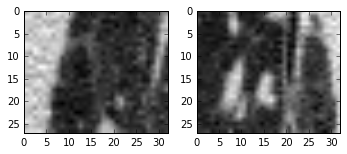

In [112]:
low_acc_roi = None
high_acc_roi = None
counter = 5
for roi_id in low_acc_ds:
    if counter != 0:
        counter -= 1
        continue
    low_acc_roi = low_acc_ds[roi_id]
    high_acc_roi = high_acc_ds[roi_id]
    print(high_acc_roi.cube.shape)
    print('--')
    print(low_acc_roi.cube.shape)
    h = high_acc_roi.cube
    l = low_acc_roi.cube
    show_slice_correct(h[5:,5:,:], l[:,:,:])
    break

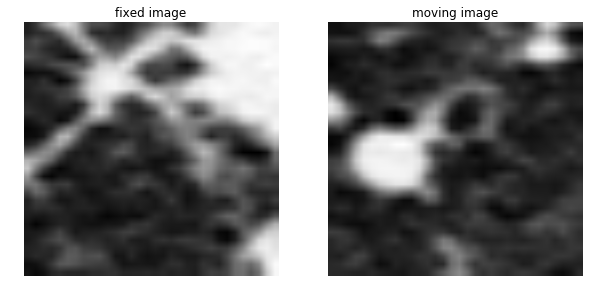

In [81]:
fixed_image =  sitk.GetImageFromArray(low_acc_roi.cube)
moving_image = sitk.GetImageFromArray(high_acc_roi.cube)

interact(display_images, fixed_image_z=(0,fixed_image.GetSize()[2]-1), moving_image_z=(0,moving_image.GetSize()[2]-1), fixed_npa = fixed(sitk.GetArrayFromImage(fixed_image)), moving_npa=fixed(sitk.GetArrayFromImage(moving_image)));


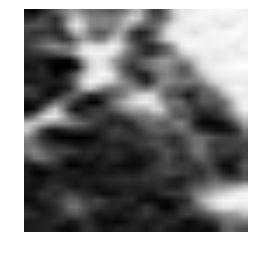

In [90]:
initial_transform = sitk.TranslationTransform(3, [0, 0, 0])

moving_resampled = sitk.Resample(moving_image, fixed_image, initial_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelIDValue())

interact(display_images_with_alpha, image_z=(0,fixed_image.GetSize()[2]), alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(moving_resampled));

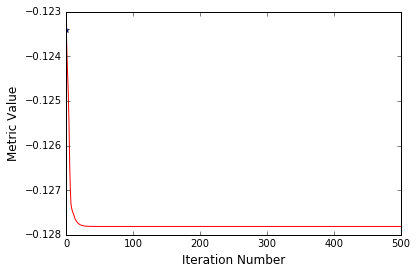

In [104]:
initial_transform = sitk.TranslationTransform(3, [0, 0, 0])

registration_method = sitk.ImageRegistrationMethod()

#similarity metric settings
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.1)

registration_method.SetInterpolator(sitk.sitkLinear)

#optimizer settings
registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=500, convergenceMinimumValue=1e-20, convergenceWindowSize=50)
# registration_method.SetOptimizerScalesFromPhysicalShift()

#setup for the multi-resolution framework            
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [1])
#registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[0])
#registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

#don't optimize in-place, we would possibly like to run this cell multiple times
registration_method.SetInitialTransform(initial_transform, inPlace=False)

#connect all of the observers so that we can perform plotting during registration
registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method))

final_transform = registration_method.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32), 
                                              sitk.Cast(moving_image, sitk.sitkFloat32))

In [105]:
print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))

Final metric value: -0.12781331404650836
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Maximum number of iterations (500) exceeded.


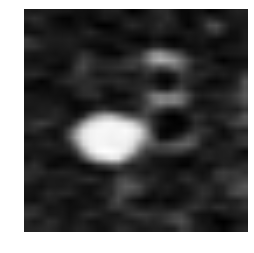

In [106]:
moving_resampled = sitk.Resample(moving_image, fixed_image, final_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelIDValue())

interact(display_images_with_alpha, image_z=(0,fixed_image.GetSize()[2]), alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(moving_resampled));